In [32]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import re
import joblib
import seaborn as sns
import datetime
import os
# from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, get_scorer_names
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from xgboost import XGBRegressor
from copy import deepcopy
warnings.filterwarnings("ignore")

## 데이터 전처리

### 경유가, 전월비, 배추가격, 거래량

In [33]:
df = pd.read_csv("./data/merge_all/merge_drop.csv")
# df.head()

In [34]:
df.head()

,거래년월일,자동차용 경유 가격 (원),전월비(%),평균,거래량
0,2000-01-03,583.35,4.0,5600.0,102285.0
1,2000-01-04,583.35,4.0,5600.0,715338.0
2,2000-01-05,583.35,4.0,5620.0,340568.0
3,2000-01-06,583.35,4.0,5700.0,290180.0
4,2000-01-07,583.35,4.0,5670.0,536736.0


In [35]:
# 예측하고자 하는 날짜의 전일을 기준으로 이동평균을 생성
move_avr = [1,5, 6, 20, 24, 60, 72, 300]
for avr in move_avr : 
    df["이동평균가_"+str(avr)+"일"] = df["평균"].shift(1).rolling(window=avr).mean()

In [36]:
df.dropna(how="any", inplace=True)     # 이동평균이 null 값인 행은 drop
# df.info()

In [37]:
df["거래년월일"] = pd.to_datetime(df["거래년월일"])
df.set_index("거래년월일", inplace=True)

In [38]:
df = df[['자동차용 경유 가격 (원)', '전월비(%)', '거래량', "이동평균가_1일", '이동평균가_5일', '이동평균가_6일',
       '이동평균가_20일', '이동평균가_24일', '이동평균가_60일', '이동평균가_72일', '이동평균가_300일', '평균']]

In [39]:
df.rename(columns={"평균":"배추가격"},inplace=True)
# df.info()

### 기후 데이터 가공

In [40]:
df_weather = pd.read_csv("data/최종_최종__월별기상관측.csv", encoding="cp949")
df_weather.head()

,Unnamed: 0,행정구역,지점명,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,0,강원도,속초,2000-01,-0.4,9.9,-10.9,90.2,152.990
1,1,강원도,속초,2000-02,-0.1,9.2,-8.6,8.4,329.070
2,2,강원도,속초,2000-03,6.9,18.5,-4.2,8.7,448.650
3,3,강원도,속초,2000-04,11.2,24.1,2.4,23.4,486.355
4,4,강원도,속초,2000-05,14.3,30.5,6.2,71.0,520.280


In [41]:
df_weather.drop(columns=df_weather.columns[0], inplace=True) 

In [42]:
df_weather["일시"] = df_weather["일시"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m"))   # datetime으로 변경

In [43]:
df_wt = df_weather.groupby(["행정구역","일시"]).median()    # 행정구역, 일시로 groupby 후 중앙값으로 대체

In [44]:
df_wt.reset_index(inplace=True)   # 멀티 인덱스를 리셋

In [45]:
df_wt_gw = df_wt[df_wt["행정구역"]=="강원도"]    # 강원도인 부분만 추출

In [46]:
# df[df_wt_gw.columns] = np.nan

In [47]:
# df.drop(columns=["행정구역", "일시"],inplace=True)

In [48]:
df_wt_gw.set_index("일시", inplace=True)

In [51]:
df_wt_gw.drop(columns="행정구역", inplace=True)
df_con = pd.concat([df, df_wt_gw], axis=1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5624 entries, 2000-01-01 to 2022-11-30
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   자동차용 경유 가격 (원)      5482 non-null   float64
 1   전월비(%)              5482 non-null   float64
 2   거래량                 5482 non-null   float64
 3   이동평균가_1일            5482 non-null   float64
 4   이동평균가_5일            5482 non-null   float64
 5   이동평균가_6일            5482 non-null   float64
 6   이동평균가_20일           5482 non-null   float64
 7   이동평균가_24일           5482 non-null   float64
 8   이동평균가_60일           5482 non-null   float64
 9   이동평균가_72일           5482 non-null   float64
 10  이동평균가_300일          5482 non-null   float64
 11  배추가격                5482 non-null   float64
 12  평균기온(°C)            264 non-null    float64
 13  최고기온(°C)            264 non-null    float64
 14  최저기온(°C)            264 non-null    float64
 15  월합강수량(00~24h만)(mm)  264 non-null    f

,자동차용 경유 가격 (원),전월비(%),거래량,이동평균가_1일,이동평균가_5일,이동평균가_6일,이동평균가_20일,이동평균가_24일,이동평균가_60일,이동평균가_72일,이동평균가_300일,배추가격,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.9,8.5,-16.0,48.1,152.990
2000-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3,7.7,-15.8,5.7,329.070
2000-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,19.3,-8.6,14.1,448.650
2000-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.4,23.7,-3.1,37.1,486.355
2000-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.9,31.6,3.9,75.2,520.280


,자동차용 경유 가격 (원),전월비(%),거래량,이동평균가_1일,이동평균가_5일,이동평균가_6일,이동평균가_20일,이동평균가_24일,이동평균가_60일,이동평균가_72일,이동평균가_300일,배추가격,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
2021-02-01,1263.36,6.8,286130.0,6624.0,6084.0,5970.666667,5293.05,5076.250000,5085.225000,5307.229167,10099.461667,6324.0,1.15,19.45,-12.8,4.9,352.26
2021-02-02,1263.36,6.8,254510.0,6324.0,6244.0,6124.000000,5402.75,5174.708333,5116.625000,5280.020833,10095.708333,6424.0,NaN,NaN,NaN,NaN,NaN
2021-02-03,1263.36,6.8,532058.0,6424.0,6444.0,6274.000000,5501.25,5275.020833,5149.691667,5255.868056,10091.621667,6524.0,NaN,NaN,NaN,NaN,NaN
2021-02-04,1263.36,6.8,486420.0,6524.0,6484.0,6457.333333,5599.75,5379.500000,5177.758333,5243.381944,10086.868333,6684.0,NaN,NaN,NaN,NaN,NaN
2021-02-05,1263.36,6.8,559770.0,6684.0,6516.0,6517.333333,5711.25,5492.375000,5200.158333,5243.743056,10082.648333,7350.0,NaN,NaN,NaN,NaN,NaN
2021-02-08,1263.36,6.8,293342.0,7350.0,6661.2,6655.000000,5856.05,5626.541667,5237.325000,5252.770833,10079.981667,6500.0,NaN,NaN,NaN,NaN,NaN
2021-02-09,1263.36,6.8,303381.0,6500.0,6696.4,6634.333333,5952.35,5711.791667,5251.991667,5251.659722,10072.315000,6900.0,NaN,NaN,NaN,NaN,NaN
2021-02-10,1263.36,6.8,516230.0,6900.0,6791.6,6730.333333,6035.50,5809.541667,5273.325000,5256.104167,10062.648333,7487.0,NaN,NaN,NaN,NaN,NaN
2021-02-15,1263.36,6.8,256850.0,7487.0,6984.2,6907.500000,6148.00,5935.916667,5286.941667,5278.979167,10054.938333,7300.0,NaN,NaN,NaN,NaN,NaN
2021-02-16,1263.36,6.8,455140.0,7300.0,7107.4,7036.833333,6246.15,6054.500000,5313.608333,5309.256944,10046.605000,7600.0,NaN,NaN,NaN,NaN,NaN


In [56]:
df_con = df_con.fillna(method="ffill")
# df_con[(pd.DatetimeIndex(df_con.index).year >= 2021) & (pd.DatetimeIndex(df_con.index).month == 2)]

,자동차용 경유 가격 (원),전월비(%),거래량,이동평균가_1일,이동평균가_5일,이동평균가_6일,이동평균가_20일,이동평균가_24일,이동평균가_60일,이동평균가_72일,이동평균가_300일,배추가격,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
2021-02-01,1263.36,6.8,286130.0,6624.0,6084.0,5970.666667,5293.05,5076.250000,5085.225000,5307.229167,10099.461667,6324.0,1.15,19.45,-12.8,4.90,352.26
2021-02-02,1263.36,6.8,254510.0,6324.0,6244.0,6124.000000,5402.75,5174.708333,5116.625000,5280.020833,10095.708333,6424.0,1.15,19.45,-12.8,4.90,352.26
2021-02-03,1263.36,6.8,532058.0,6424.0,6444.0,6274.000000,5501.25,5275.020833,5149.691667,5255.868056,10091.621667,6524.0,1.15,19.45,-12.8,4.90,352.26
2021-02-04,1263.36,6.8,486420.0,6524.0,6484.0,6457.333333,5599.75,5379.500000,5177.758333,5243.381944,10086.868333,6684.0,1.15,19.45,-12.8,4.90,352.26
2021-02-05,1263.36,6.8,559770.0,6684.0,6516.0,6517.333333,5711.25,5492.375000,5200.158333,5243.743056,10082.648333,7350.0,1.15,19.45,-12.8,4.90,352.26
2021-02-08,1263.36,6.8,293342.0,7350.0,6661.2,6655.000000,5856.05,5626.541667,5237.325000,5252.770833,10079.981667,6500.0,1.15,19.45,-12.8,4.90,352.26
2021-02-09,1263.36,6.8,303381.0,6500.0,6696.4,6634.333333,5952.35,5711.791667,5251.991667,5251.659722,10072.315000,6900.0,1.15,19.45,-12.8,4.90,352.26
2021-02-10,1263.36,6.8,516230.0,6900.0,6791.6,6730.333333,6035.50,5809.541667,5273.325000,5256.104167,10062.648333,7487.0,1.15,19.45,-12.8,4.90,352.26
2021-02-15,1263.36,6.8,256850.0,7487.0,6984.2,6907.500000,6148.00,5935.916667,5286.941667,5278.979167,10054.938333,7300.0,1.15,19.45,-12.8,4.90,352.26
2021-02-16,1263.36,6.8,455140.0,7300.0,7107.4,7036.833333,6246.15,6054.500000,5313.608333,5309.256944,10046.605000,7600.0,1.15,19.45,-12.8,4.90,352.26


In [65]:
df_finish = df_con[df_con.index >= "2001-01-11"]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5611 entries, 2001-01-11 to 2022-11-30
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   자동차용 경유 가격 (원)      5611 non-null   float64
 1   전월비(%)              5611 non-null   float64
 2   거래량                 5611 non-null   float64
 3   이동평균가_1일            5611 non-null   float64
 4   이동평균가_5일            5611 non-null   float64
 5   이동평균가_6일            5611 non-null   float64
 6   이동평균가_20일           5611 non-null   float64
 7   이동평균가_24일           5611 non-null   float64
 8   이동평균가_60일           5611 non-null   float64
 9   이동평균가_72일           5611 non-null   float64
 10  이동평균가_300일          5611 non-null   float64
 11  배추가격                5611 non-null   float64
 12  평균기온(°C)            5611 non-null   float64
 13  최고기온(°C)            5611 non-null   float64
 14  최저기온(°C)            5611 non-null   float64
 15  월합강수량(00~24h만)(mm)  5611 non-null   f

,자동차용 경유 가격 (원),전월비(%),거래량,이동평균가_1일,이동평균가_5일,이동평균가_6일,이동평균가_20일,이동평균가_24일,이동평균가_60일,이동평균가_72일,이동평균가_300일,배추가격,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
2001-01-11,660.99,8.2,285105.0,1900.0,1904.0,1896.666667,1826.5,1848.750000,2088.683333,2396.138889,4683.080000,1900.0,-6.1,7.3,-23.5,37.2,257.045
2001-01-12,660.99,8.2,114353.0,1900.0,1912.0,1903.333333,1823.0,1846.666667,2062.933333,2364.611111,4670.746667,1900.0,-6.1,7.3,-23.5,37.2,257.045
2001-01-13,660.99,8.2,345429.0,1900.0,1924.0,1910.000000,1824.0,1844.583333,2040.266667,2332.527778,4658.413333,1900.0,-6.1,7.3,-23.5,37.2,257.045
2001-01-15,660.99,8.2,86106.0,1900.0,1908.0,1920.000000,1829.5,1841.666667,2020.933333,2302.527778,4646.013333,2040.0,-6.1,7.3,-23.5,37.2,257.045
2001-01-16,660.99,8.2,64551.0,2040.0,1928.0,1930.000000,1844.0,1844.583333,2004.850000,2275.027778,4633.813333,2160.0,-6.1,7.3,-23.5,37.2,257.045


### feature, target 분리 후 scaling

In [66]:
feature = df_finish.drop(columns=["자동차용 경유 가격 (원)","거래량", "전월비(%)", "배추가격", "이동평균가_1일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"])
target = df_finish["배추가격"]

In [67]:
## MinMaxScaler를 이용한 정규화
mmsc_feat = MinMaxScaler()
mmsc_tar = MinMaxScaler()

mmsc_feat.fit(feature)
mmsc_tar.fit(target.values.reshape(-1,1))

X = mmsc_feat.transform(feature)
y = mmsc_tar.transform(target.values.reshape(-1,1))

In [ ]:
## trainset과 testset을 분리

In [68]:
len_x = int(len(X)*0.8)
len_y = int(len(y)*0.8)

X_train, X_test = X[:len_x], X[len_x:]
y_train, y_test = y[:len_y], y[len_y:]

In [43]:
mmsc2_feat = MinMaxScaler()
mmsc2_tar = MinMaxScaler()

mmsc2_feat.fit(feature)
mmsc2_tar.fit(target.values.reshape(-1,1))

X2 = mmsc2_feat.transform(feature)
y2 = mmsc2_tar.transform(target.values.reshape(-1,1))

In [44]:
len_X2 = len(feature[feature.index <= "2022-10-31"])

In [45]:
X_train2, X_test2 = X2[:len_X2], X2[len_X2:]
y_train2, y_test2 = y2[:len_X2], y2[len_X2:]

## GridSearchCV를 통한 xgboost의 최적의 파라미터 찾기

In [69]:
kfold = KFold(n_splits=5, shuffle=False)

eta = np.logspace(-3,2,6)   # xgboost 해당
n_estimators = [15,20,50,100,200,500]   # randomforesteregressor(사용할 tree의 개수), gradientboost, adaboost, xgboost 해당
max_depth = [2,3,5,7,10,12]  # randomforesteregressor(tree의 깊이), gradientboost, xgboost 해당
gamma = [0, 0.05, 0.1, 0.2, 0.5]    # xgboost 해당
max_leaf_nodes = [2,3,5,7]     # randomforest, xgboost 해당
min_child_weight = [1,2,3,5]   # xgboost 해당

params_xgb = {"learning_rate" : eta,
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                "gamma" : gamma,
                "min_child_weight" : min_child_weight}

In [70]:
xgb_grid = XGBRegressor()
grid_xgb = GridSearchCV(estimator=xgb_grid, param_grid=params_xgb, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_xgb.fit(X_train, y_train)
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)


-0.0003966470076590435
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 200}


## xgboostregressor를 이용한 모델 학습

In [81]:
# GridSearchCV를 통해 찾은 파라미터를 이용한 xgboostregressor
em = grid_xgb.best_estimator_
y_pred = em.predict(X_test)
print("r2 score :", r2_score(y_test, y_pred))


r2 score : 0.7677677435452566


In [86]:
y_pred_train = em.predict(X_train)
print("r2 score :", r2_score(y_train, y_pred_train))

r2 score : 0.9817935801184635


In [82]:
# 역정규화
y_tst_inv = mmsc_tar.inverse_transform(y_test)
y_pred_inv = mmsc_tar.inverse_transform(y_pred.reshape(-1,1))

print(y_tst_inv.shape)
print(y_pred_inv.shape)

(1123, 1)
(1123, 1)


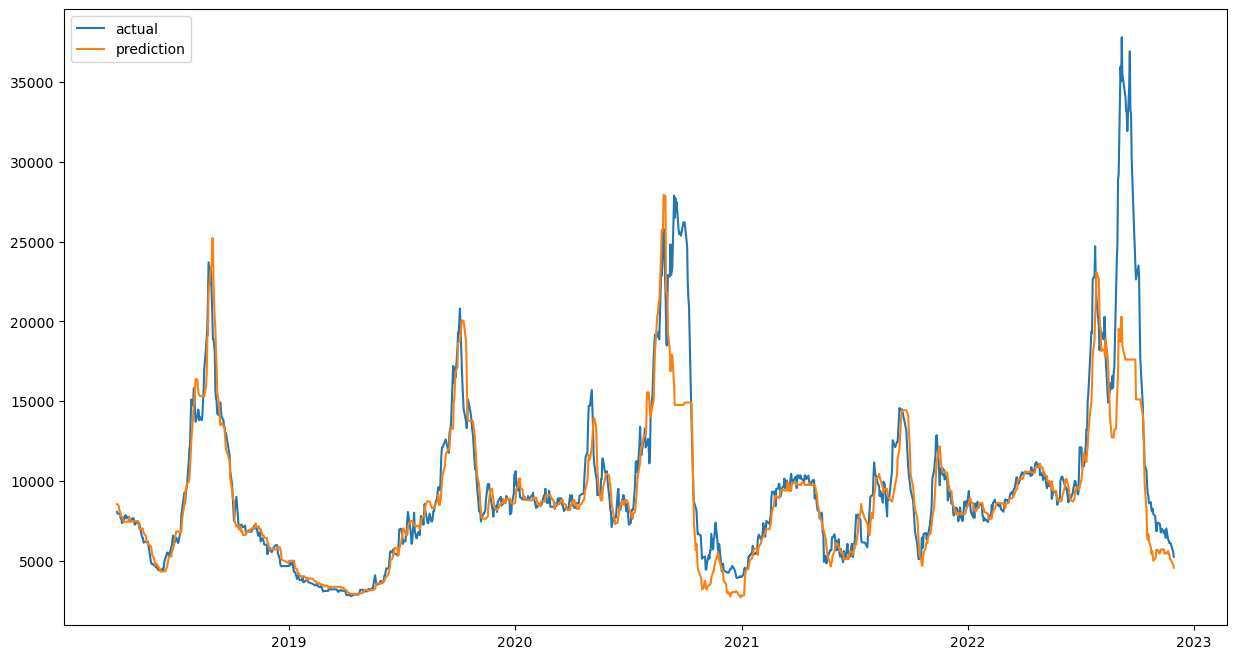

In [83]:
fig = plt.figure(figsize=(15,8))
plt.plot(target.index[len_y:], y_tst_inv.reshape(-1), label="actual")
plt.plot(target.index[len_y:], y_pred_inv.reshape(-1), label="prediction")
plt.legend()
plt.show()

In [84]:
# 오차율
y_diff = (y_pred_inv-y_tst_inv)/y_tst_inv*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


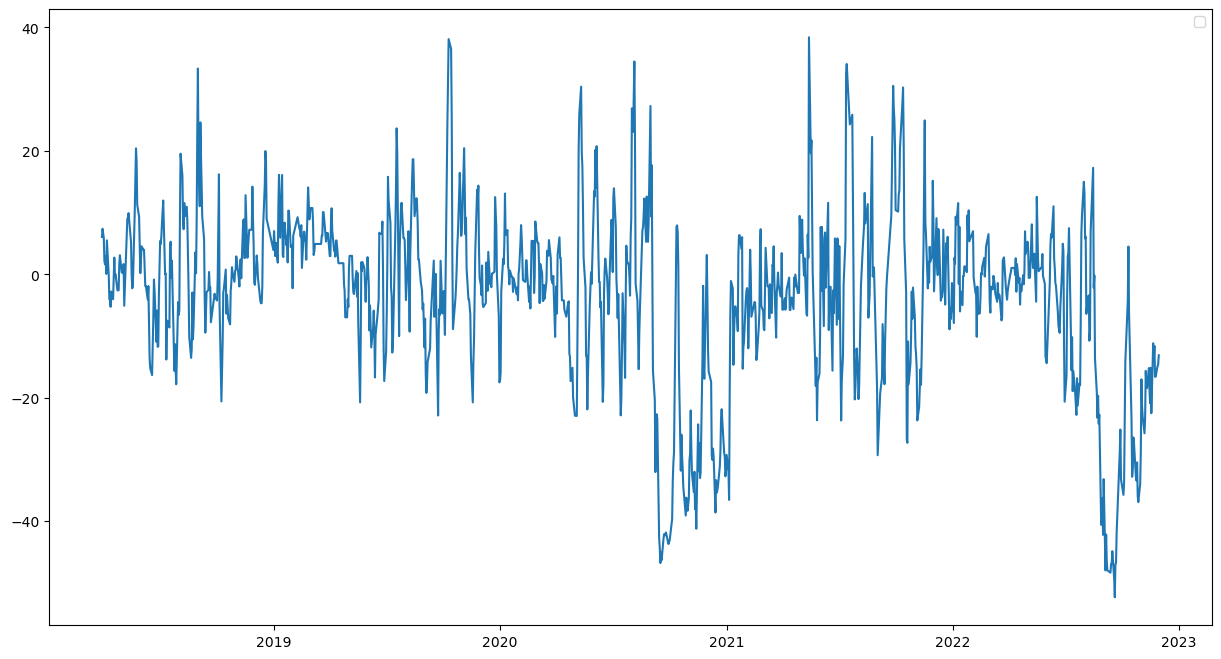

In [85]:
fig = plt.figure(figsize=(15,8))
plt.plot(target.index[len_y:], y_diff.reshape(-1))
# plt.plot(target.index[len_y:], 0)
plt.legend()
plt.show()

## LSTM 모델을 통한 예측

In [34]:
# 데이터를 3차원으로 변경
# X_train2 = X_train2.reshape(-1, 1, 4)
# X_test2 = X_test2.reshape(-1, 1, 4)

X_train = X_train.reshape(-1, 1, 4)
X_test = X_test.reshape(-1, 1, 4)

# print(X_train2.shape)
# print(X_test2.shape)


In [36]:
# train set를 다시 train set와 valid set로 나눔
# X_train_L, X_valid_L, y_train_L, y_valid_L = train_test_split(X_train2, y_train2, test_size=0.1, shuffle=False, random_state=2)
X_train_L, X_valid_L, y_train_L, y_valid_L = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, random_state=2)


In [37]:
model = Sequential()
# model.add(LSTM(16, 
#                 input_shape=(X_train2.shape[1], X_train2.shape[2]),
#                 activation="relu",
#                 recurrent_activation="tanh",
#                 dropout=0.1))

model.add(LSTM(16, 
                input_shape=(X_train.shape[1], X_train.shape[2]),
                activation="relu",
                recurrent_activation="tanh",
                dropout=0.1))

model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="relu"))

In [39]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode="min")

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train_L, y_train_L, 
                                    epochs=1000, 
                                    batch_size=10,
                                    validation_data=(X_valid_L, y_valid_L), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/1000
393/395 [============================>.] - ETA: 0s - loss: 6.9977e-04 - mean_squared_error: 6.9977e-04
Epoch 00001: val_loss improved from inf to 0.00137, saving model to model\tmp_checkpoint.h5
395/395 [==============================] - 3s 2ms/step - loss: 6.9896e-04 - mean_squared_error: 6.9896e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/1000
395/395 [==============================] - ETA: 0s - loss: 7.6530e-04 - mean_squared_error: 7.6530e-04
Epoch 00002: val_loss improved from 0.00137 to 0.00086, saving model to model\tmp_checkpoint.h5
395/395 [==============================] - 1s 2ms/step - loss: 7.6530e-04 - mean_squared_error: 7.6530e-04 - val_loss: 8.5734e-04 - val_mean_squared_error: 8.5734e-04
Epoch 3/1000
383/395 [============================>.] - ETA: 0s - loss: 7.2855e-04 - mean_squared_error: 7.2855e-04
Epoch 00003: val_loss did not improve from 0.00086
395/395 [==============================] - 1s 2ms/step - loss: 7.3672e-04 - mean_square

In [40]:
y_pred = model.predict(X_test2)
print("R2 Score :", r2_score(y_test2, y_pred))
# print(y_pred.shape)
# print(y_test2.shape)

R2 Score : 0.09438561552226687


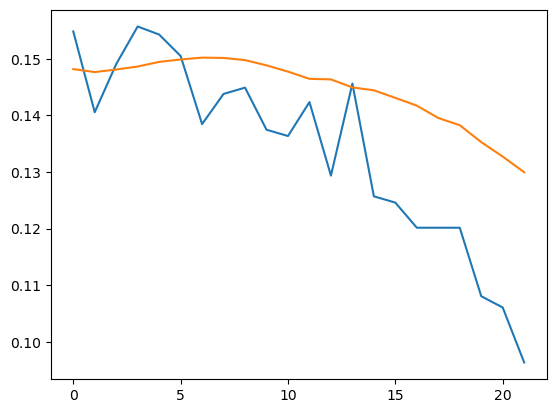

In [41]:
plt.plot(y_test2.tolist())
plt.plot(y_pred.tolist())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


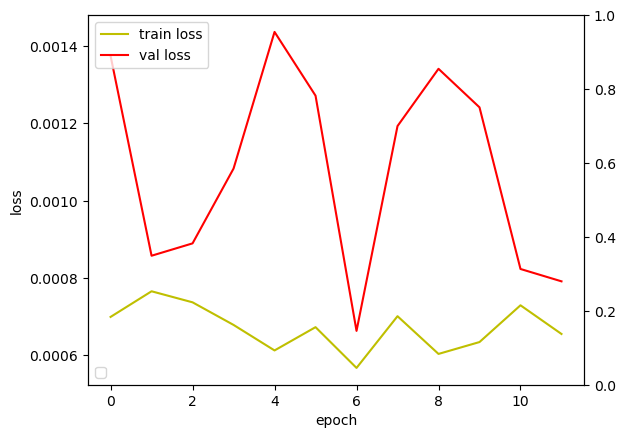

In [42]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
# acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
# acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

## 2021년 11월부터 예측을 위한 frame 생성

In [204]:
# dt = input("예측 날짜를 설정해 주세요 :")
# def pred_price_for_user(start_date, end_date) : 
# df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))
df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))
# df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_6일", "이동평균가_20일","이동평균가_24일", "이동평균가_72일", "이동평균가_300일"]))
# df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_20일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))
# df_202110 = deepcopy(df[df.index < "2021-09-01"][["이동평균가_5일", "이동평균가_300일", "배추가격"]])

df_202110.head()

,이동평균가_5일,이동평균가_20일,이동평균가_60일,이동평균가_300일,배추가격
거래년월일,,,,,
2001-01-11,1904.0,1826.5,2088.683333,4683.080000,1900.0
2001-01-12,1912.0,1823.0,2062.933333,4670.746667,1900.0
2001-01-13,1924.0,1824.0,2040.266667,4658.413333,1900.0
2001-01-15,1908.0,1829.5,2020.933333,4646.013333,2040.0
2001-01-16,1928.0,1844.0,2004.850000,4633.813333,2160.0


In [145]:
# df_202110[df_202110["배추가격"].isnull()]

In [207]:
start_date = datetime.datetime.strptime("2021-11-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2022-11-01", "%Y-%m-%d")
print(end_date-start_date)

365 days, 0:00:00


In [208]:
date_diff = end_date-start_date
date_diff.days

365

In [209]:
# start_date + datetime.timedelta(days=1)
pred_price_list = []

start_copy = deepcopy(start_date)

move_avr2 = [5,20,60,300]


for i in range(date_diff.days) :    # 시작 날짜와 끝 날짜로 작동하는 for문 생성

    len_of_202110 = len(df_202110)

    row_list = []     # 새로운 행에 삽입될 이동평균 값을 저장할 리스트
    
    if start_copy in df.index.to_list() :      # 해당 날짜가 df.index에 들어있다면(공휴일을 계산할 수 없기에(?))
    
        for k in range(len(move_avr2)) : 
            mov_mean = df_202110.iloc[(len_of_202110-move_avr2[k]):len_of_202110,-1].mean()  #df_202110 프레임에 새로운 이동평균 행을 추가
            row_list.append(mov_mean)

        row_list.append(np.nan)

        df_202110.loc[start_copy] = row_list

        pred_baechoo = xgb.predict(minmaxscale)    # xgb 모델을 통한 가격 예측

        pred_baechoo = mmsc_tar.inverse_transform(pred_baechoo.reshape(-1,1))

        pred_price_list.extend(pred_baechoo)    # 예측된 가격을 저장

        df_202110.loc[start_copy, "배추가격"] = pred_baechoo    # 예측된 가격을 새로 추가된 행에 배추 가격에 삽입
            
    start_copy += datetime.timedelta(days=1)


In [183]:
# df_202110[(df_202110.index < "2021-10-01") & (df_202110.index >= "2021-09-01")]

In [182]:
# df_202110[(df_202110.index < "2021-11-01") & (df_202110.index >= "2021-10-01")]

In [181]:
# df_202110[(df_202110.index < "2021-12-01") & (df_202110.index >= "2021-11-01")]

In [180]:
# df[(df.index < "2021-12-01") & (df.index >= "2021-11-01")]

In [282]:
# df_202110[(df_202110.index >= "2021-11-01")]

In [283]:
# df_202110.tail(30)

In [210]:
y_extract = df[(df.index >= "2021-11-01") & (df.index < "2022-11-01")]["배추가격"].to_list()

In [92]:
y_extract[0]

7205.0

In [211]:
print(r2_score(y_extract, pred_price_list))

-0.6483094535457501


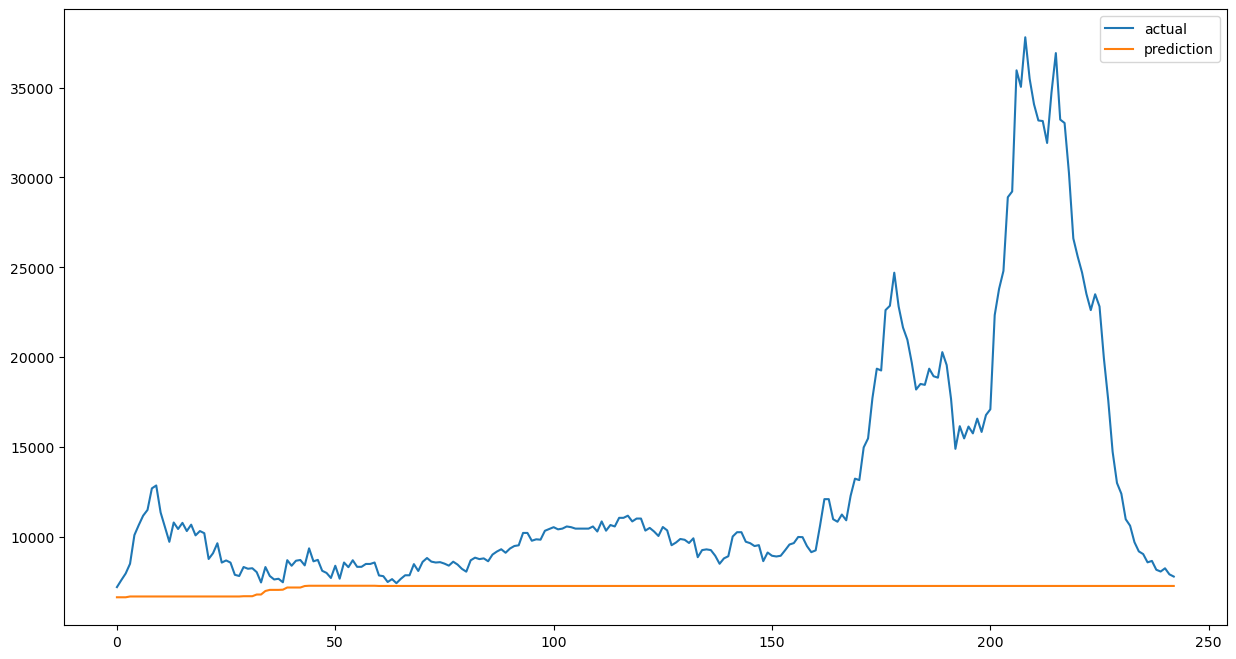

In [212]:
fig = plt.figure(figsize=(15,8))
plt.plot(y_extract, label="actual")
plt.plot(pred_price_list, label="prediction")
plt.legend()
plt.show()

<AxesSubplot:>

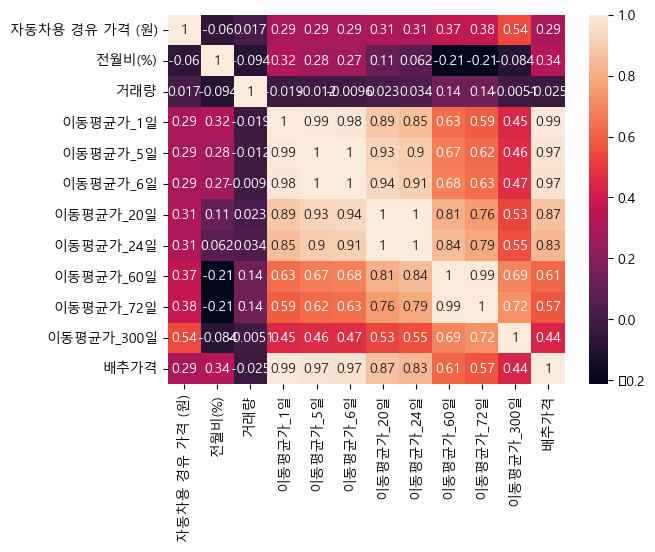

In [48]:
from matplotlib import rc

df_corr = df.corr("pearson")

plt.rcParams['font.family'] = 'Malgun Gothic'
sns.heatmap(df_corr, cbar=True ,annot=True)

## 12월 예측

In [84]:
## 12월 테스트용 데이터 프레임 만들기
df_price = pd.read_csv("./data/price/price_baechoo.csv")
df_price.set_index("구분", inplace=True)   # 구분 column을 인덱스로 설정
df_price.rename(columns={"평균" : "배추가격"})
df_price = df_price[df_price.index >= "2022-12-01"]
df_price.index.name = ""
df_price.index = pd.to_datetime(df_price.index)


In [85]:
df_price.rename(columns={"평균":"배추가격"}, inplace=True)

In [86]:
df_202211 = deepcopy(df.drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))

start_date = datetime.datetime.strptime("2022-12-01", "%Y-%m-%d")
# end_date = datetime.datetime.strptime("2022-12-21", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2023-06-01", "%Y-%m-%d")


date_diff = end_date-start_date
# start_date + datetime.timedelta(days=1)
pred_price_list = []

start_copy = deepcopy(start_date)

move_avr2 = [5,20,60,300]

for i in range(date_diff.days) :    # 시작 날짜와 끝 날짜로 작동하는 for문 생성

    len_of_202211 = len(df_202211)

    row_list = []     # 새로운 행에 삽입될 이동평균 값을 저장할 리스트
    
    if start_copy in df_price.index.to_list() :      # 해당 날짜가 df_price.index에 들어있다면(공휴일을 계산할 수 없기에(?))
    
        for k in range(len(move_avr2)) : 
            mov_mean = df_202211.iloc[(len_of_202211-move_avr2[k]):len_of_202211,-1].mean()  #df_202110 프레임에 새로운 이동평균 행을 추가
            row_list.append(mov_mean)

        row_list.append(np.nan)

        df_202211.loc[start_copy] = row_list

        # 새로 추가된 feature 행을 scaling
        minmaxscale = mmsc_feat.transform(df_202211.loc[start_copy,["이동평균가_5일","이동평균가_20일","이동평균가_60일","이동평균가_300일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_1일","이동평균가_5일","이동평균가_20일","이동평균가_60일","이동평균가_300일"]].values.reshape(1,-1))   
        
        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일","이동평균가_60일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일","이동평균가_60일", "이동평균가_300일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일", "이동평균가_300일"]].values.reshape(1,-1))   

        pred_baechoo = xgb.predict(minmaxscale)    # xgb 모델을 통한 가격 예측

        pred_baechoo = mmsc_tar.inverse_transform(pred_baechoo.reshape(-1,1))

        pred_price_list.extend(pred_baechoo)    # 예측된 가격을 저장

        df_202211.loc[start_copy, "배추가격"] = pred_baechoo    # 예측된 가격을 새로 추가된 행에 배추 가격에 삽입
            
    start_copy += datetime.timedelta(days=1)


In [282]:
# pred_price_list

In [87]:
actual_price = np.array(df_price["배추가격"].to_list()).reshape(-1,1)

In [88]:
predict_price_array = np.array(pred_price_list).reshape(-1,1)

In [74]:
print("r2_score :", r2_score(df_price["배추가격"].to_list(), pred_price_list))

r2_score : -1.2674036138840776


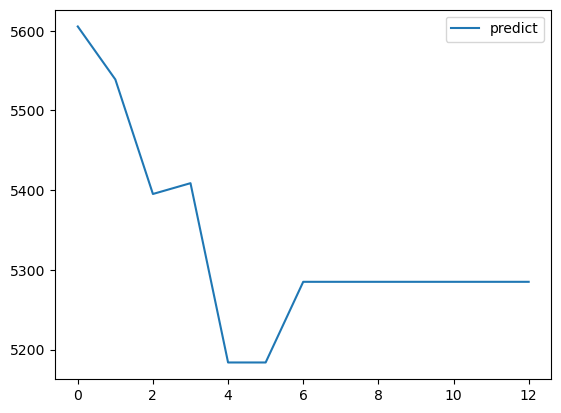

In [89]:
# plt.plot(df_price["배추가격"].to_list(), label="actual")
plt.plot(pred_price_list, label="predict")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


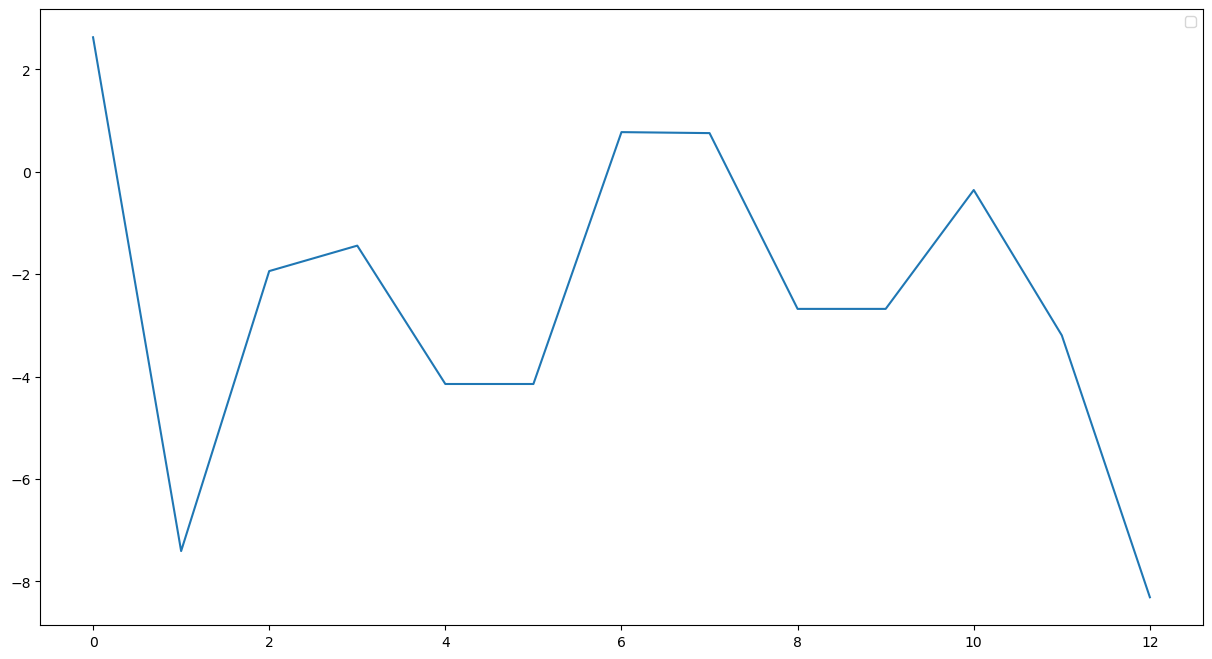

In [281]:
# 오차율
y_diff = ((predict_price_array-actual_price)/actual_price)*100
fig = plt.figure(figsize=(15,8))
plt.plot(y_diff)
# plt.plot(target.index[len_y:], 0)
plt.legend()
plt.show()